<a href="https://colab.research.google.com/github/naeldarw/DLAV/blob/main/DLAV_Phase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLAV Project - Phase 1

In this notebook we will train a very simple planner on data coming from a driving simulator. You are given a dash cam image of the current state of the driving vehicle, and the past positions of this vehicle, and you are asked to plan its future route.

This notebook will take you through steps on building this planner to solve the task. The full skeleton of the code together with some very simple implementations of each module are provided for your comfort. So all the cells below will run without you needing to change anything, but the performance won't be very good. You are asked to re-implement and play with most of the modules yourself to be able to have better performance.

P.S. to enable fast compute, you should use GPUs in google colab. The code works without GPUs, but it'll be much faster to use GPUs, specially if your model gets bigger and bigger! You can utilize Colab's GPUs by selecting "Change runtime type" in the Runtime menu on top of this page. There you can select "T4 GPU". This would restart your runtime, so you'll need to re-run everything from the top.

The first step is to prepare the data. The code below will download the data from google drive and extract it here for your code to use. Whenever your session gets restarted, remember to re-run this cell to re-download the data.

In [1]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = "dlav_val.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = "dlav_test_public.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=4c98f31c-0696-4a1e-bec3-ffd8dd3a0af9
To: /content/dlav_train.zip
100%|██████████| 439M/439M [00:01<00:00, 282MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu
From (redirected): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu&confirm=t&uuid=8bd25c05-492c-4ec7-9d09-2704653dd52d
To: /content/dlav_val.zip
100%|██████████| 87.8M/87.8M [00:05<00:00, 15.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV
From (redirected): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV&confirm=t&uuid=9900197a-50be-4945-9f5d-20660cc894fd
To: /content/dlav_test_public.zip
100%|██████████| 86.6M/86.6M [00:01<00:00, 55.3MB/s]


Now lets load the data and visualize the first few examples to see what we are dealing with!

camera data shape is (200, 300, 3)
camera data shape is (200, 300, 3)
camera data shape is (200, 300, 3)
camera data shape is (200, 300, 3)


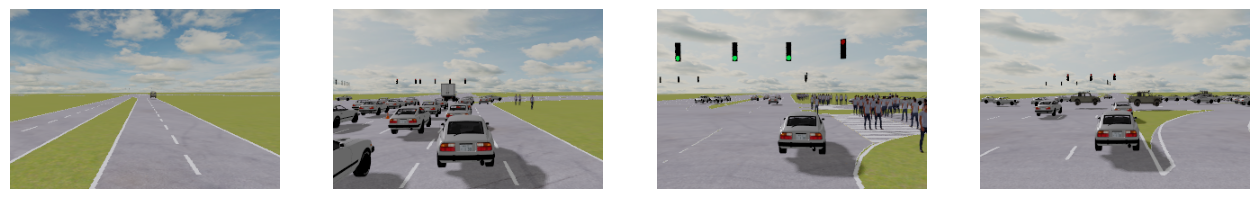

[[[159 162 162]
  [158 162 163]
  [158 163 163]
  ...
  [ 90 127 153]
  [ 94 128 155]
  [ 92 126 153]]

 [[155 161 161]
  [154 159 161]
  [152 159 161]
  ...
  [ 87 125 153]
  [ 86 125 153]
  [ 83 123 153]]

 [[153 161 160]
  [151 158 159]
  [151 158 159]
  ...
  [ 85 125 153]
  [ 83 124 153]
  [ 82 124 153]]

 ...

 [[140 147  73]
  [142 146  73]
  [144 146  73]
  ...
  [149 145 154]
  [152 148 156]
  [152 148 156]]

 [[133 143  69]
  [136 141  71]
  [141 144  77]
  ...
  [152 148 156]
  [152 148 156]
  [151 147 155]]

 [[130 139  66]
  [132 141  70]
  [131 140  73]
  ...
  [157 153 161]
  [158 155 163]
  [159 156 164]]]
[[[190 193 194]
  [190 193 193]
  [190 194 193]
  ...
  [111 138 159]
  [110 138 159]
  [110 138 159]]

 [[191 194 195]
  [189 193 194]
  [188 192 194]
  ...
  [111 139 159]
  [111 139 159]
  [110 138 159]]

 [[192 194 194]
  [192 194 194]
  [191 194 194]
  ...
  [111 139 159]
  [111 139 159]
  [110 138 158]]

 ...

 [[ 99  97 100]
  [102  99 102]
  [101  99 101]
  ..

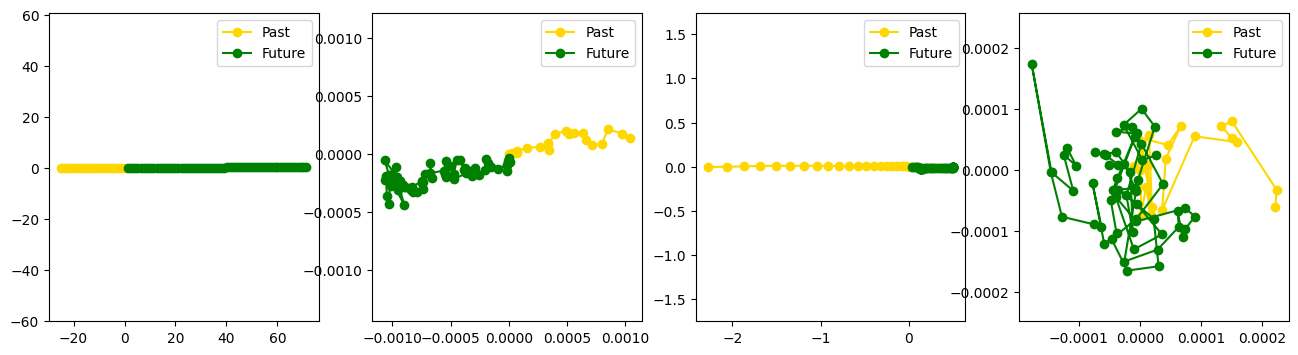

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random

k = 4
# load the data
data = []
for i in random.choices(np.arange(1000), k=k):
    with open(f"train/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    camera_data = data[i]["camera"]
    axis[i].imshow(camera_data)
    print(f"camera data shape is {camera_data.shape}")
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    #print(data[i]["sdc_history_feature"])
    print(data[i]["camera"])
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now its time to make our hands dirty!

In the following cells we will define the classes we need to do a proper training in pytorch.

1. We will start with defining a Dataset class which loads the data and does some basic preprocessing. You can further process this data as you see fit.
2. We then define the logger which receives training metrics and logs and prints/visualizes them. Having a good logger means a lot when dealing with neural network training! The logger implemented here is very simple and we strongly suggest you try other ways of visualizing your losses and metrics. Be creative ;)
3. We then proceed with defining the core part of the pipeline, the model. You are going to mainly implement the model yourself, but we have provided a very simple model so that the code runs as is so that you can see how the whole framework runs all in all.
4. Finally, we define the training funciton which contains the training loop, and we call it to see the magic! You'll need to also do a lot of changes here, from the batch size and learning rate, to adding augmentation schemes and schedulers, etc.

In [3]:
import os
import pickle
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.optim as optim

class DrivingDataset(Dataset):
    def __init__(self, file_list, transform=None, test=False):
        """
        file_list: list of .pkl paths
        transform : torchvision transforms to apply to the camera image
        test      : whether to include future label
        """
        self.samples  = file_list
        self.transform = transform
        self.test     = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # 1) load
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        # 2) camera: H×W×C numpy array (uint8 or float32)
        img_np = data['camera']
        # ensure uint8 for PIL
        if img_np.dtype != np.uint8:
            # if float in [0,1], scale up; else clip/round
            img_np = (255 * img_np).clip(0,255).astype(np.uint8)

        img = Image.fromarray(img_np)           # PIL Image
        if self.transform:
            camera = self.transform(img)         # tensor [C,H,W]
        else:
            # default: just to-tensor
            camera = T.ToTensor()(img)

        # 3) history / (future)
        history = torch.FloatTensor(data['sdc_history_feature'])
        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {'camera': camera, 'history': history, 'future': future}
        else:
            return {'camera': camera, 'history': history}

In [4]:
class Logger:
    def __init__(self):
        # Placeholder for potential future configs (e.g., log_dir, wandb_enabled, etc.)
        pass

    def log(self, step=None, **metrics):
        """
        Logs the given metrics.

        Args:
            step (int, optional): The current step or epoch. Useful for tracking.
            **metrics: Arbitrary keyword arguments representing metric names and values.
        """
        prefix = f"[Step {step}] " if step is not None else ""
        metric_str = " | ".join(f"{k}: {v}" for k, v in metrics.items())
        # print(prefix + metric_str)

In [5]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Splits an image into patches.

    Parameters:
        x (torch.Tensor): Image tensor of shape [B, C, H, W].
        patch_size (int): Size of each patch (patches are patch_size x patch_size).
        flatten_channels (bool): If True, each patch is flattened into a vector.

    Returns:
        torch.Tensor: A tensor of patches.
            - If flatten_channels is True, the output shape is [B, num_patches, C * patch_size * patch_size].
            - If False, the output shape is [B, num_patches, C, patch_size, patch_size],
            where num_patches = (H / patch_size) * (W / patch_size).
    """
    B, C, H, W = x.shape
    num_patches = (H // patch_size) * (W // patch_size)
    # TODO : Implement the split into patches
    # Personal Trick to use torch.Tensor.unfold: the unfolding dimension is always replaced by the number of slices, and a new dimension size of the slice is added in the end.
    # Thus, try to match the required shape.
    x = x.unfold(2, patch_size, patch_size) # Output shape should be [B, num_patches, C * patch_size * patch_size]
    x = x.unfold(3, patch_size, patch_size)
    x = torch.permute(x, (0, 2, 3, 1, 4, 5))
    if flatten_channels:
      x = torch.reshape(x, (B, num_patches, C * patch_size * patch_size))
    else:
      x = torch.reshape(x, (B, num_patches, C, patch_size, patch_size))
    return x

In [6]:
import torch
import torch.nn as nn

class VisionTransformer(nn.Module):
    def __init__(self,
                 embed_dim,
                 hidden_dim,
                 num_channels,
                 num_heads,
                 num_layers,
                 patch_size,
                 num_patches,
                 dropout=0.1):
        super().__init__()
        self.patch_size   = patch_size

        # 1) Patch embedding layer
        self.patch_embedding = nn.Linear(
            num_channels * (patch_size ** 2),
            embed_dim
        )

        # 2) Class token & positional embeddings
        self.cls_token     = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

        # 3) Embedding dropout
        self.dropout       = nn.Dropout(dropout)

        # 4) Transformer encoder stack
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)


    def forward(self, x):
        """
        x: (B, num_channels, H, W)
        """
        B = x.shape[0]

        # returns (B, num_patches, num_channels * patch_size^2)
        x = img_to_patch(x, self.patch_size)

        # linear projection to embed_dim
        x = self.patch_embedding(x)                # (B, num_patches, embed_dim)

        # prepend class token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)      # (B, num_patches+1, embed_dim)

        # add positional embeddings & dropout
        x = x + self.pos_embedding
        x = self.dropout(x)

        # transformer layers
        x = self.transformer(x)                    # (B, num_patches+1, embed_dim)

        return x[:, 0, :]


In [7]:
import torch
import torch.nn as nn

class DrivingPlanner(nn.Module):
    def __init__(self,
                 img_h=200, img_w=300,
                 history_steps=21,
                 future_steps=60,
                 cnn_dropout=0.5,
                 vt_embed_dim=64,
                 vt_hidden_dim=128,
                 vt_heads=2,
                 vt_layers=2,
                 vt_patch_size=10):
        super().__init__()
        self.future_steps  = future_steps
        self.history_steps = history_steps

        # 1) cnn backbone
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(6),
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(cnn_dropout)
        )

        # compute number of patches from CNN feature map dims
        Hp, Wp = img_h // 4, img_w // 4
        num_patches = (Hp // vt_patch_size) * (Wp // vt_patch_size)

        # 2)vision transformer
        self.vit = VisionTransformer(
            embed_dim=vt_embed_dim,
            hidden_dim=vt_hidden_dim,
            num_channels=6,
            num_heads=vt_heads,
            num_layers=vt_layers,
            patch_size=vt_patch_size,
            num_patches=num_patches,
            dropout=0.1
        )

        # 3) Final decoder: fuse CLS + history
        decoder_in  = vt_embed_dim + history_steps * 3
        decoder_out = future_steps * 3
        self.decoder = nn.Sequential(
            nn.Linear(decoder_in, decoder_out),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(decoder_out, decoder_out)
        )

        # 4) Parameter count
        total_params = sum(p.numel() for p in self.parameters())
        print(f"[DrivingPlanner] Total parameters: {total_params/1e6:.2f}M")

    def forward(self, camera, history):
        B = camera.size(0)
        # 1)cnn feature map(B, C=chanels, H/4, W/4)
        feat_map = self.cnn_backbone(camera)
        # 2) get global image embedding
        img_emb = self.vit(feat_map)                      # (B, vt_embed_dim)
        # 3)merge with history
        hist_flat = history.view(B, -1)                   # (B, history_steps*3)
        fused = torch.cat([img_emb, hist_flat], dim=1)    # (B, decoder_in)
        # 4)decode the future trajetory
        out = self.decoder(fused)                         # (B, future_steps*3)
        return out.view(B, self.future_steps, 3)          # (B, future_steps, 3)


In [8]:
class ADELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        # compute L2 distance over the first two dims, then mean over all samples/timesteps
        return torch.norm(pred[..., :2] - target[..., :2], dim=-1).mean()

def train(model, train_loader, val_loader, optimizer, logger, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = ADELoss()

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for idx, batch in enumerate(train_loader):
            camera = batch['camera'].to(device)
            history = batch['history'].to(device)
            future = batch['future'].to(device)

            optimizer.zero_grad()
            pred_future = model(camera, history)
            loss = criterion(pred_future[..., :2], future[..., :2])
            loss.backward()
            optimizer.step()

            if idx % 10 == 0:
                logger.log(step=epoch * len(train_loader) + idx, loss=loss.item())
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss, ade_all, fde_all = 0, [], []
        with torch.no_grad():
            for batch in val_loader:
                camera = batch['camera'].to(device)
                history = batch['history'].to(device)
                future = batch['future'].to(device)

                pred_future = model(camera, history)
                loss = criterion(pred_future, future)
                ADE = torch.norm(pred_future[:, :, :2] - future[:, :, :2], p=2, dim=-1).mean()
                FDE = torch.norm(pred_future[:, -1, :2] - future[:, -1, :2], p=2, dim=-1).mean()
                ade_all.append(ADE.item())
                fde_all.append(FDE.item())
                val_loss += loss.item()
        scheduler.step(val_loss)
        print(f"Learning rate: {optimizer.param_groups[0]['lr']}")




        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | ADE: {np.mean(ade_all):.4f} | FDE: {np.mean(fde_all):.4f}')

In [10]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

# Set up transforms
IMG_H, IMG_W = 200, 300

train_transform = T.Compose([
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
])

val_transform = T.Compose([
    T.Resize((IMG_H, IMG_W)),
    T.ToTensor(),
])

# Build dataset
train_data_dir = "train"
val_data_dir = "val"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

train_dataset = DrivingDataset(train_files, transform=train_transform, test=False)
val_dataset   = DrivingDataset(val_files,   transform=val_transform,   test=False)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=16)

model = DrivingPlanner()

# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1)

logger = Logger()

train(model, train_loader, val_loader, optimizer, logger, num_epochs=75)


[DrivingPlanner] Total parameters: 0.16M
Learning rate: 0.001
Epoch 1/75 | Train Loss: 5.5116 | Val Loss: 3.7157 | ADE: 3.7157 | FDE: 9.0425
Learning rate: 0.001
Epoch 2/75 | Train Loss: 3.6959 | Val Loss: 3.4372 | ADE: 3.4372 | FDE: 8.6724
Learning rate: 0.001
Epoch 3/75 | Train Loss: 3.3733 | Val Loss: 3.2609 | ADE: 3.2609 | FDE: 8.4089
Learning rate: 0.001
Epoch 4/75 | Train Loss: 3.0834 | Val Loss: 2.8801 | ADE: 2.8801 | FDE: 7.7894
Learning rate: 0.001
Epoch 5/75 | Train Loss: 2.8452 | Val Loss: 2.8821 | ADE: 2.8821 | FDE: 7.7038
Learning rate: 0.001
Epoch 6/75 | Train Loss: 2.6787 | Val Loss: 2.6251 | ADE: 2.6251 | FDE: 7.2348
Learning rate: 0.001
Epoch 7/75 | Train Loss: 2.5622 | Val Loss: 2.4437 | ADE: 2.4437 | FDE: 6.9866
Learning rate: 0.001
Epoch 8/75 | Train Loss: 2.4843 | Val Loss: 2.3949 | ADE: 2.3949 | FDE: 6.7925
Learning rate: 0.001
Epoch 9/75 | Train Loss: 2.4359 | Val Loss: 2.3329 | ADE: 2.3329 | FDE: 6.6602
Learning rate: 0.001
Epoch 10/75 | Train Loss: 2.4280 | Val

By running the code above, you have trained your first model!
What do you observe in terms of train and val losses? What is this phenomenon called? (Explain in a few lines below)




This model is very simple and does not necessarilly yield the optimal performance. You are asked to implement your own neural network architecture. You can use convolution networks, vision transformers, etc. Try with different architectures, different model sizes, and other hyper parameters such as learning rate and batch size to find the best performance. Other ideas could be to use augmentation thechniques to boost the performance, adding learning rate schedulers, and exploring other loss functions.

Once you are happy with your model, continue with the rest of the notebook to save your checkpoint and also visualize some plans coming from the model. The last cell will provide a `submission_phase1.csv` which you can submit to the leaderboard to see your results on the testing set.

In [11]:
# save the model
torch.save(model.state_dict(), "phase1_model.pth")

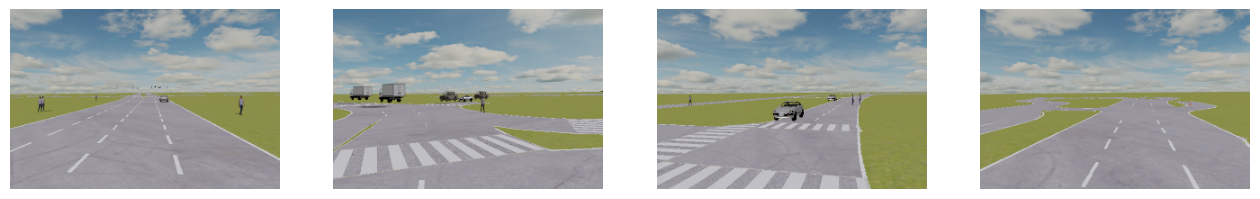

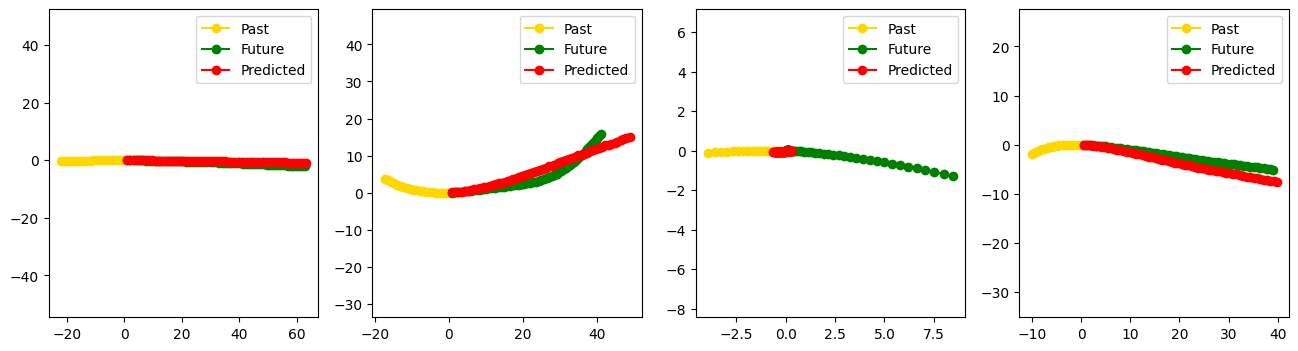

In [20]:
val_batch_zero = next(iter(val_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
camera = val_batch_zero['camera'].to(device)
history = val_batch_zero['history'].to(device)
future = val_batch_zero['future'].to(device)

model.eval()
with torch.no_grad():
    pred_future = model(camera, history)

camera = camera.cpu().numpy()
history = history.cpu().numpy()
future = future.cpu().numpy()
pred_future = pred_future.cpu().numpy()
k=4
selected_indices = random.choices(np.arange(len(camera)), k=k)
# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].imshow(camera[idx].transpose(1, 2, 0))
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].plot(history[idx, :, 0], history[idx, :, 1], "o-", color="gold", label="Past")
    axis[i].plot(future[idx, :, 0], future[idx, :, 1], "o-", color="green", label="Future")
    axis[i].plot(pred_future[idx, :, 0], pred_future[idx, :, 1], "o-", color="red", label="Predicted")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called `submission_phase1.csv` by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [21]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [22]:
import pandas as pd
test_data_dir = "test_public"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]

test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)
model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future = model(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase1.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
